# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

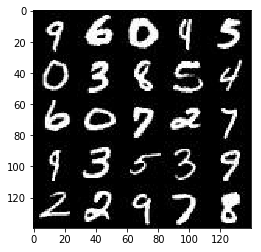

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

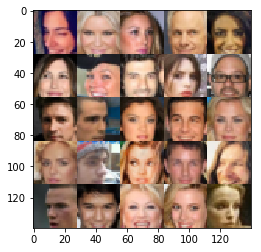

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    t_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), 't_real')
    t_z = tf.placeholder(tf.float32, (None, z_dim), 't_z')
    learn_rate = tf.placeholder(tf.float32, name='learn_rate')

    return t_real, t_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [73]:
alpha = 0.1
keep_prob = 0.9

In [74]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 64, 3, padding='same')
        out1 = tf.maximum(conv1 * alpha, conv1)
        
        conv2 = tf.layers.conv2d(out1, 128, 3, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        out2 = tf.maximum(conv2 * alpha, conv2)
        out2 = tf.nn.dropout(out2, keep_prob=keep_prob)
        
        conv3 = tf.layers.conv2d(out2, 256, 3, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        out3 = tf.maximum(conv3 * alpha, conv3)
        out3 = tf.nn.dropout(out3, keep_prob=keep_prob)
        
        flat = tf.reshape(out3, (-1, 28 * 28 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [75]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        dense = tf.layers.dense(z, 28 * 28 * 512)

        x = tf.reshape(dense, (-1, 28, 28, 512))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        
        conv1 = tf.layers.conv2d_transpose(x, 256, 3, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(conv1 * alpha, conv1)

        conv2 = tf.layers.conv2d_transpose(conv1, 128, 3, padding='same')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(conv2 * alpha, conv2)
        
        conv3 = tf.layers.conv2d_transpose(x, 64, 3, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(conv3 * alpha, conv3)
        
        
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 3, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [76]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
                            
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [77]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [78]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [89]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    real, z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(real, z, image_channels)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    saver = tf.train.Saver()
    min_g_loss = 1000
    min_d_loss = 1000
    steps = 0
    total_steps = epoch_count * batch_size
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                
                _ = sess.run(d_train_opt, feed_dict={
                    real: batch_images,
                    z: batch_z,
                    learn_rate: learning_rate
                })
                _ = sess.run(g_train_opt, feed_dict={
                    real: batch_images,
                    z: batch_z,
                    learn_rate: learning_rate
                })
                if steps == 1:
                    print('initial output')
                    show_generator_output(sess, 16, z, image_channels, data_image_mode)
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({ real: batch_images, z: batch_z })
                    train_loss_g = g_loss.eval({ real: batch_images, z: batch_z })
                    if train_loss_d < min_d_loss and train_loss_g < min_g_loss:
                        min_g_loss = train_loss_g
                        min_d_loss = train_loss_d
                        print("Saving new low loss",
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                        saver.save(sess, './generator.ckpt')
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % 50 == 0:
                    show_generator_output(sess, 16, z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output


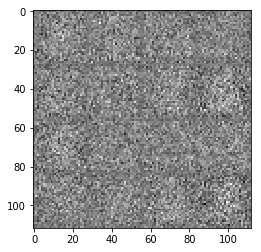

Saving new low loss Discriminator Loss: 0.2164... Generator Loss: 2.2122
Epoch 1/2... Discriminator Loss: 0.2164... Generator Loss: 2.2122
Epoch 1/2... Discriminator Loss: 0.0404... Generator Loss: 6.7714
Epoch 1/2... Discriminator Loss: 2.0585... Generator Loss: 1.7164
Epoch 1/2... Discriminator Loss: 2.5528... Generator Loss: 4.2248
Epoch 1/2... Discriminator Loss: 1.7587... Generator Loss: 0.9826


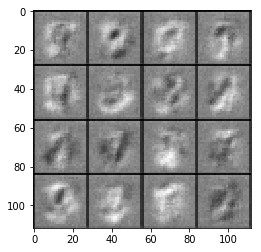

Epoch 1/2... Discriminator Loss: 5.3119... Generator Loss: 0.0086
Epoch 1/2... Discriminator Loss: 0.8017... Generator Loss: 1.1615
Epoch 1/2... Discriminator Loss: 0.6098... Generator Loss: 8.2826
Epoch 1/2... Discriminator Loss: 0.6215... Generator Loss: 1.9541
Epoch 1/2... Discriminator Loss: 0.2275... Generator Loss: 2.3273


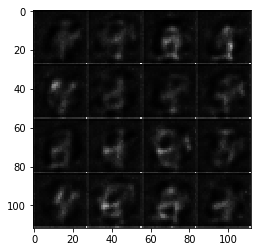

Epoch 1/2... Discriminator Loss: 0.1687... Generator Loss: 2.7350
Epoch 1/2... Discriminator Loss: 0.2622... Generator Loss: 2.1816
Epoch 1/2... Discriminator Loss: 0.0911... Generator Loss: 3.4534
Epoch 1/2... Discriminator Loss: 0.0977... Generator Loss: 3.2465
Epoch 1/2... Discriminator Loss: 0.0819... Generator Loss: 3.3780


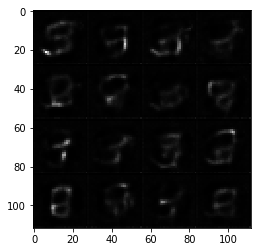

Epoch 1/2... Discriminator Loss: 0.0518... Generator Loss: 3.5491
Epoch 1/2... Discriminator Loss: 0.0496... Generator Loss: 3.6592
Epoch 1/2... Discriminator Loss: 0.0541... Generator Loss: 3.6041
Epoch 1/2... Discriminator Loss: 0.0638... Generator Loss: 3.5287
Epoch 1/2... Discriminator Loss: 0.0528... Generator Loss: 3.5789


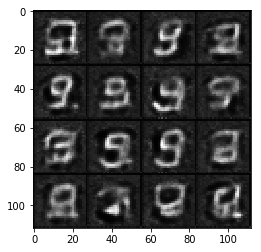

Epoch 1/2... Discriminator Loss: 0.0363... Generator Loss: 3.9753
Epoch 1/2... Discriminator Loss: 0.0419... Generator Loss: 3.6321
Epoch 1/2... Discriminator Loss: 0.0748... Generator Loss: 3.1936
Epoch 1/2... Discriminator Loss: 0.1090... Generator Loss: 2.7298
Epoch 1/2... Discriminator Loss: 0.0054... Generator Loss: 9.8306


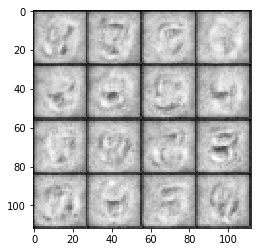

Epoch 1/2... Discriminator Loss: 0.0399... Generator Loss: 6.4424
Epoch 1/2... Discriminator Loss: 2.6949... Generator Loss: 9.1978
Epoch 1/2... Discriminator Loss: 4.7920... Generator Loss: 0.0881
Epoch 1/2... Discriminator Loss: 0.7325... Generator Loss: 1.3932
Epoch 1/2... Discriminator Loss: 0.6259... Generator Loss: 1.1752


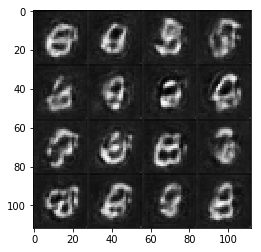

Epoch 1/2... Discriminator Loss: 0.0277... Generator Loss: 8.7468
Epoch 1/2... Discriminator Loss: 4.5833... Generator Loss: 0.1528
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 1.2698
Epoch 1/2... Discriminator Loss: 0.4123... Generator Loss: 1.9533
Epoch 1/2... Discriminator Loss: 0.2179... Generator Loss: 2.2747


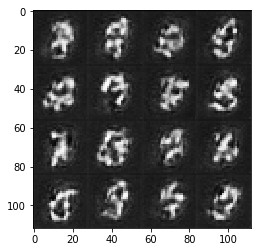

Epoch 1/2... Discriminator Loss: 0.0492... Generator Loss: 3.8888
Epoch 1/2... Discriminator Loss: 0.0248... Generator Loss: 6.6865
Epoch 1/2... Discriminator Loss: 0.0614... Generator Loss: 3.7770
Epoch 1/2... Discriminator Loss: 0.0042... Generator Loss: 13.2776
Epoch 1/2... Discriminator Loss: 0.0045... Generator Loss: 8.7450


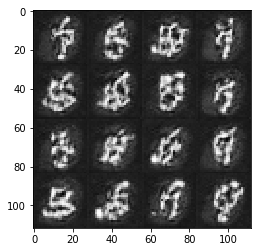

Epoch 1/2... Discriminator Loss: 0.0369... Generator Loss: 4.1517
Epoch 1/2... Discriminator Loss: 0.0050... Generator Loss: 17.2028
Epoch 1/2... Discriminator Loss: 0.0425... Generator Loss: 3.9089
Epoch 1/2... Discriminator Loss: 0.0484... Generator Loss: 3.7112
Epoch 1/2... Discriminator Loss: 0.1043... Generator Loss: 2.8841


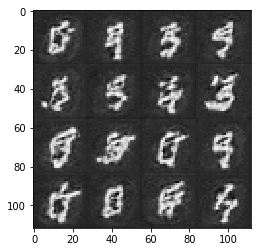

Epoch 1/2... Discriminator Loss: 0.0312... Generator Loss: 6.2370
Epoch 1/2... Discriminator Loss: 0.0088... Generator Loss: 17.0043
Epoch 1/2... Discriminator Loss: 0.2731... Generator Loss: 2.0364
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 18.6095
Epoch 1/2... Discriminator Loss: 1.3017... Generator Loss: 2.0498


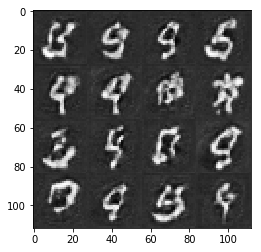

Epoch 1/2... Discriminator Loss: 0.0120... Generator Loss: 9.7483
Epoch 1/2... Discriminator Loss: 0.0166... Generator Loss: 17.7321
Epoch 1/2... Discriminator Loss: 0.4359... Generator Loss: 2.0018
Epoch 1/2... Discriminator Loss: 0.1668... Generator Loss: 3.6916
Epoch 1/2... Discriminator Loss: 0.3849... Generator Loss: 2.1855


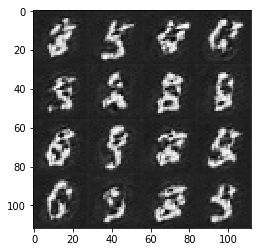

Epoch 1/2... Discriminator Loss: 0.3115... Generator Loss: 1.9027
Epoch 1/2... Discriminator Loss: 0.0963... Generator Loss: 3.5192
Epoch 1/2... Discriminator Loss: 0.0087... Generator Loss: 13.8438
Epoch 1/2... Discriminator Loss: 0.0061... Generator Loss: 15.4895
Epoch 1/2... Discriminator Loss: 0.0054... Generator Loss: 6.8950


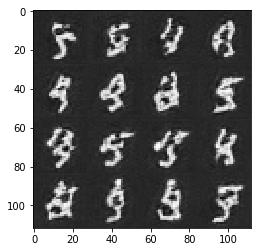

Epoch 1/2... Discriminator Loss: 0.0903... Generator Loss: 3.7057
Epoch 1/2... Discriminator Loss: 0.0329... Generator Loss: 4.4157
Epoch 1/2... Discriminator Loss: 0.0009... Generator Loss: 10.0494
Epoch 1/2... Discriminator Loss: 0.0100... Generator Loss: 7.3269
Epoch 1/2... Discriminator Loss: 0.0015... Generator Loss: 8.2722


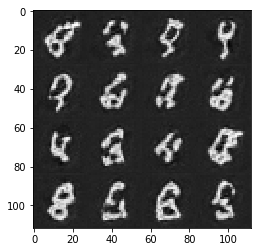

Epoch 1/2... Discriminator Loss: 0.0061... Generator Loss: 8.6537
Epoch 1/2... Discriminator Loss: 0.0600... Generator Loss: 3.7758
Epoch 1/2... Discriminator Loss: 0.0014... Generator Loss: 13.5574
Epoch 1/2... Discriminator Loss: 0.0036... Generator Loss: 10.6105
Epoch 1/2... Discriminator Loss: 0.1905... Generator Loss: 2.6046


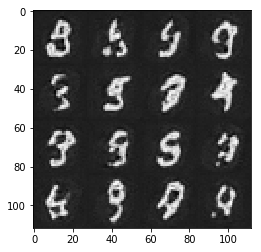

Epoch 1/2... Discriminator Loss: 0.1082... Generator Loss: 3.6260
Epoch 1/2... Discriminator Loss: 0.0607... Generator Loss: 4.7778
Epoch 1/2... Discriminator Loss: 5.1152... Generator Loss: 8.1417
Epoch 1/2... Discriminator Loss: 8.1215... Generator Loss: 0.0993
Epoch 1/2... Discriminator Loss: 3.2857... Generator Loss: 0.1909


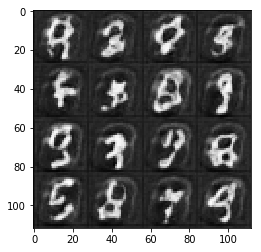

Epoch 1/2... Discriminator Loss: 4.8108... Generator Loss: 0.0465
Epoch 1/2... Discriminator Loss: 6.9154... Generator Loss: 0.0096
Epoch 1/2... Discriminator Loss: 0.6538... Generator Loss: 2.0911
Epoch 1/2... Discriminator Loss: 0.6451... Generator Loss: 2.8396
Epoch 1/2... Discriminator Loss: 0.4456... Generator Loss: 2.3016


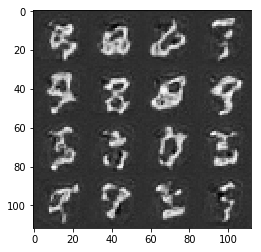

Epoch 1/2... Discriminator Loss: 0.5472... Generator Loss: 1.7792
Epoch 1/2... Discriminator Loss: 0.4968... Generator Loss: 1.4042
Epoch 1/2... Discriminator Loss: 8.7181... Generator Loss: 21.9368
Epoch 1/2... Discriminator Loss: 2.5009... Generator Loss: 10.9073
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.5662


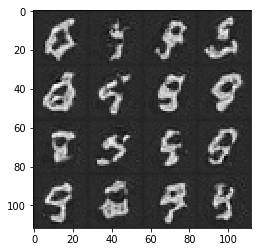

Epoch 1/2... Discriminator Loss: 0.0656... Generator Loss: 3.8454
Epoch 1/2... Discriminator Loss: 0.0013... Generator Loss: 11.6202
Epoch 1/2... Discriminator Loss: 0.6849... Generator Loss: 2.7628
Epoch 1/2... Discriminator Loss: 3.4447... Generator Loss: 13.0856
Epoch 1/2... Discriminator Loss: 0.0246... Generator Loss: 9.0403


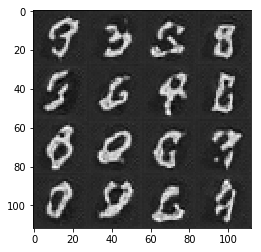

Epoch 1/2... Discriminator Loss: 0.0179... Generator Loss: 16.7707
Epoch 1/2... Discriminator Loss: 0.3017... Generator Loss: 2.8801
Epoch 1/2... Discriminator Loss: 0.0359... Generator Loss: 18.2141
Epoch 2/2... Discriminator Loss: 0.0060... Generator Loss: 17.4286
Epoch 2/2... Discriminator Loss: 0.0166... Generator Loss: 8.6491


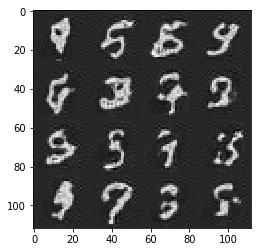

Epoch 2/2... Discriminator Loss: 0.0387... Generator Loss: 5.9260
Epoch 2/2... Discriminator Loss: 0.3727... Generator Loss: 2.3406
Epoch 2/2... Discriminator Loss: 0.0149... Generator Loss: 19.7448
Epoch 2/2... Discriminator Loss: 0.0128... Generator Loss: 7.8976
Epoch 2/2... Discriminator Loss: 0.0041... Generator Loss: 12.4092


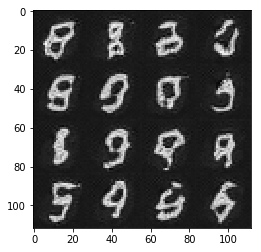

Epoch 2/2... Discriminator Loss: 0.0162... Generator Loss: 6.8917
Epoch 2/2... Discriminator Loss: 0.0310... Generator Loss: 5.1242
Epoch 2/2... Discriminator Loss: 0.1375... Generator Loss: 5.0224
Epoch 2/2... Discriminator Loss: 0.0050... Generator Loss: 13.6404
Epoch 2/2... Discriminator Loss: 0.0047... Generator Loss: 11.9184


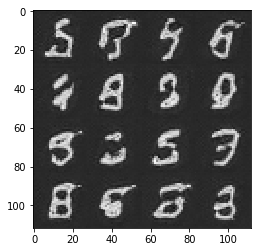

Epoch 2/2... Discriminator Loss: 0.0071... Generator Loss: 12.8685
Epoch 2/2... Discriminator Loss: 0.0014... Generator Loss: 9.1433
Epoch 2/2... Discriminator Loss: 0.4558... Generator Loss: 11.5596
Epoch 2/2... Discriminator Loss: 0.1716... Generator Loss: 3.9312
Epoch 2/2... Discriminator Loss: 0.0294... Generator Loss: 13.3755


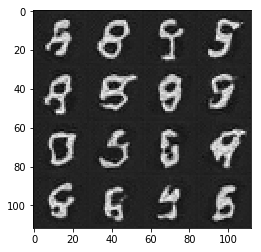

Epoch 2/2... Discriminator Loss: 0.1738... Generator Loss: 6.5398
Epoch 2/2... Discriminator Loss: 0.0016... Generator Loss: 11.3764
Epoch 2/2... Discriminator Loss: 0.0082... Generator Loss: 11.7673
Epoch 2/2... Discriminator Loss: 0.0131... Generator Loss: 8.2599
Epoch 2/2... Discriminator Loss: 0.0133... Generator Loss: 9.9132


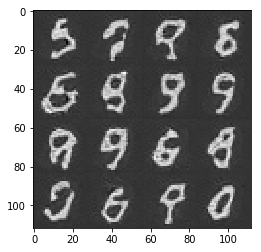

Epoch 2/2... Discriminator Loss: 0.0112... Generator Loss: 13.9880
Epoch 2/2... Discriminator Loss: 0.2022... Generator Loss: 9.7692
Epoch 2/2... Discriminator Loss: 0.0035... Generator Loss: 13.9283
Epoch 2/2... Discriminator Loss: 0.0049... Generator Loss: 7.3924
Epoch 2/2... Discriminator Loss: 0.0729... Generator Loss: 10.0961


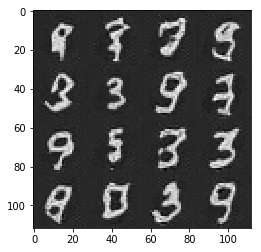

Epoch 2/2... Discriminator Loss: 0.0182... Generator Loss: 12.5237
Epoch 2/2... Discriminator Loss: 0.0824... Generator Loss: 3.8399
Epoch 2/2... Discriminator Loss: 0.0155... Generator Loss: 5.9248
Epoch 2/2... Discriminator Loss: 0.5621... Generator Loss: 1.6940
Epoch 2/2... Discriminator Loss: 0.0018... Generator Loss: 9.1527


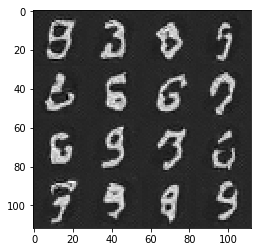

Epoch 2/2... Discriminator Loss: 0.0015... Generator Loss: 9.5065
Epoch 2/2... Discriminator Loss: 0.0043... Generator Loss: 10.1798
Epoch 2/2... Discriminator Loss: 3.0368... Generator Loss: 6.2518
Epoch 2/2... Discriminator Loss: 2.1244... Generator Loss: 1.1568
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 9.2942


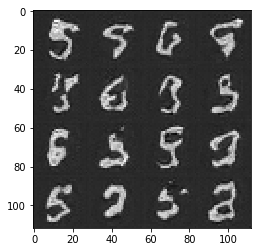

Epoch 2/2... Discriminator Loss: 4.2947... Generator Loss: 0.0675
Epoch 2/2... Discriminator Loss: 0.1195... Generator Loss: 5.0312
Epoch 2/2... Discriminator Loss: 0.0805... Generator Loss: 5.6364
Epoch 2/2... Discriminator Loss: 0.4649... Generator Loss: 2.4714
Epoch 2/2... Discriminator Loss: 0.1143... Generator Loss: 4.7168


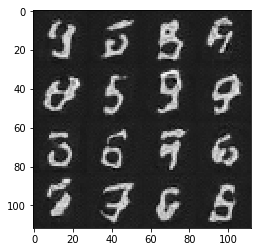

Epoch 2/2... Discriminator Loss: 1.2298... Generator Loss: 1.1650
Epoch 2/2... Discriminator Loss: 0.1376... Generator Loss: 5.3902
Epoch 2/2... Discriminator Loss: 0.0632... Generator Loss: 4.5707
Epoch 2/2... Discriminator Loss: 0.0532... Generator Loss: 11.5874
Epoch 2/2... Discriminator Loss: 0.0141... Generator Loss: 7.4387


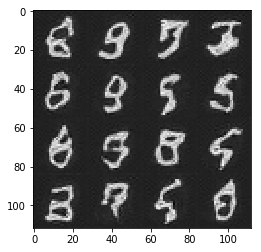

Epoch 2/2... Discriminator Loss: 0.0830... Generator Loss: 4.8249
Epoch 2/2... Discriminator Loss: 0.0546... Generator Loss: 15.1021
Epoch 2/2... Discriminator Loss: 0.0401... Generator Loss: 22.8168
Epoch 2/2... Discriminator Loss: 0.0052... Generator Loss: 10.1672
Epoch 2/2... Discriminator Loss: 0.0408... Generator Loss: 16.5680


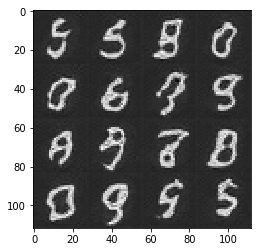

Epoch 2/2... Discriminator Loss: 0.4745... Generator Loss: 1.5508
Epoch 2/2... Discriminator Loss: 0.0275... Generator Loss: 22.5580
Epoch 2/2... Discriminator Loss: 0.0074... Generator Loss: 14.1095
Epoch 2/2... Discriminator Loss: 0.0019... Generator Loss: 17.2327
Epoch 2/2... Discriminator Loss: 0.0086... Generator Loss: 24.4966


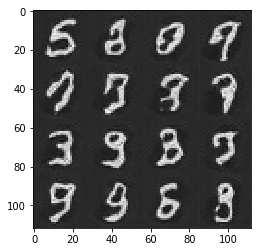

Epoch 2/2... Discriminator Loss: 0.0943... Generator Loss: 4.4431
Epoch 2/2... Discriminator Loss: 0.0087... Generator Loss: 20.4934
Epoch 2/2... Discriminator Loss: 0.0053... Generator Loss: 9.1889
Epoch 2/2... Discriminator Loss: 0.0570... Generator Loss: 4.0412
Epoch 2/2... Discriminator Loss: 2.6306... Generator Loss: 0.2801


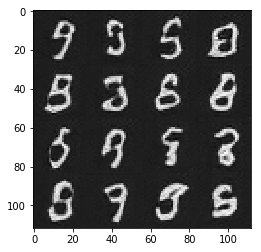

Epoch 2/2... Discriminator Loss: 1.2608... Generator Loss: 1.4143
Epoch 2/2... Discriminator Loss: 0.2523... Generator Loss: 5.3662
Epoch 2/2... Discriminator Loss: 0.1477... Generator Loss: 9.1912
Epoch 2/2... Discriminator Loss: 0.1385... Generator Loss: 4.7009
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 1.3702


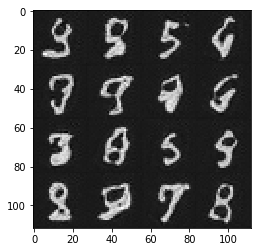

Epoch 2/2... Discriminator Loss: 0.0358... Generator Loss: 6.0443
Epoch 2/2... Discriminator Loss: 0.0579... Generator Loss: 9.2640
Epoch 2/2... Discriminator Loss: 0.0036... Generator Loss: 20.2614
Epoch 2/2... Discriminator Loss: 0.3280... Generator Loss: 2.7704
Epoch 2/2... Discriminator Loss: 0.2520... Generator Loss: 3.6656


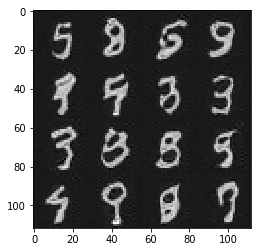

Epoch 2/2... Discriminator Loss: 0.2027... Generator Loss: 3.9681
Epoch 2/2... Discriminator Loss: 0.0066... Generator Loss: 14.9683
Epoch 2/2... Discriminator Loss: 0.0018... Generator Loss: 22.4924
Epoch 2/2... Discriminator Loss: 0.2271... Generator Loss: 3.0162
Epoch 2/2... Discriminator Loss: 0.0206... Generator Loss: 12.1653


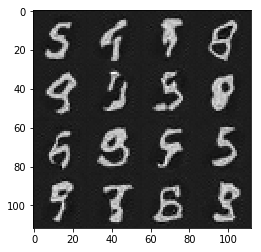

Epoch 2/2... Discriminator Loss: 0.0059... Generator Loss: 10.9403
Epoch 2/2... Discriminator Loss: 0.0138... Generator Loss: 8.5911
Epoch 2/2... Discriminator Loss: 0.0281... Generator Loss: 9.7646
Epoch 2/2... Discriminator Loss: 0.0012... Generator Loss: 9.8575
Epoch 2/2... Discriminator Loss: 0.0236... Generator Loss: 12.5607


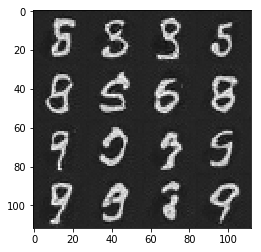

Epoch 2/2... Discriminator Loss: 0.0618... Generator Loss: 18.3379
Epoch 2/2... Discriminator Loss: 0.0229... Generator Loss: 8.4239
Epoch 2/2... Discriminator Loss: 12.8618... Generator Loss: 26.8312
Epoch 2/2... Discriminator Loss: 0.4792... Generator Loss: 3.4705
Epoch 2/2... Discriminator Loss: 0.3407... Generator Loss: 2.8815


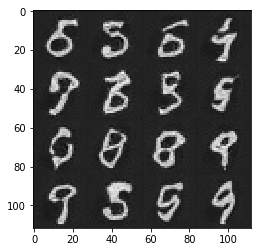

Epoch 2/2... Discriminator Loss: 0.2510... Generator Loss: 4.9129
Epoch 2/2... Discriminator Loss: 0.4661... Generator Loss: 8.5013
Epoch 2/2... Discriminator Loss: 0.6867... Generator Loss: 19.1591
Epoch 2/2... Discriminator Loss: 0.0123... Generator Loss: 9.9175
Epoch 2/2... Discriminator Loss: 0.2320... Generator Loss: 5.4320


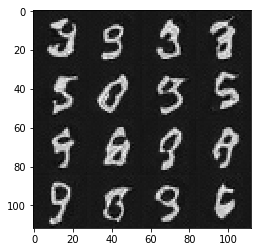

Epoch 2/2... Discriminator Loss: 0.0206... Generator Loss: 15.9008
Epoch 2/2... Discriminator Loss: 0.0244... Generator Loss: 9.4287


In [101]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output


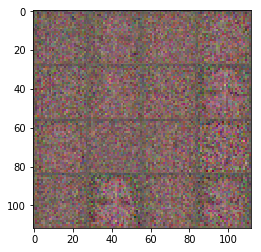

Saving new low loss Discriminator Loss: 5.5070... Generator Loss: 0.0128
Epoch 1/1... Discriminator Loss: 5.5070... Generator Loss: 0.0128
Epoch 1/1... Discriminator Loss: 7.5109... Generator Loss: 20.5794
Epoch 1/1... Discriminator Loss: 11.7585... Generator Loss: 13.8852
Epoch 1/1... Discriminator Loss: 5.1015... Generator Loss: 7.1272
Epoch 1/1... Discriminator Loss: 3.8905... Generator Loss: 11.3673


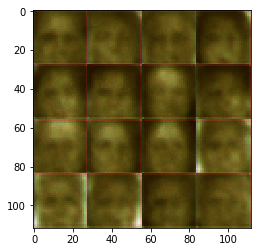

Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 3.0130
Epoch 1/1... Discriminator Loss: 11.2493... Generator Loss: 17.1813
Epoch 1/1... Discriminator Loss: 4.7285... Generator Loss: 7.8954
Epoch 1/1... Discriminator Loss: 6.3484... Generator Loss: 10.4881
Epoch 1/1... Discriminator Loss: 2.4138... Generator Loss: 7.0334


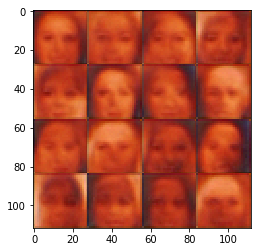

Epoch 1/1... Discriminator Loss: 0.3961... Generator Loss: 7.2683
Epoch 1/1... Discriminator Loss: 3.3487... Generator Loss: 0.3809
Epoch 1/1... Discriminator Loss: 8.8778... Generator Loss: 0.0440
Epoch 1/1... Discriminator Loss: 4.7950... Generator Loss: 0.1443
Epoch 1/1... Discriminator Loss: 5.4258... Generator Loss: 0.0524


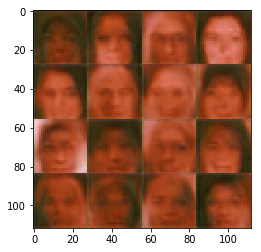

Epoch 1/1... Discriminator Loss: 6.7491... Generator Loss: 0.0836
Epoch 1/1... Discriminator Loss: 1.7622... Generator Loss: 18.6549
Epoch 1/1... Discriminator Loss: 4.7097... Generator Loss: 0.2456
Epoch 1/1... Discriminator Loss: 5.5949... Generator Loss: 7.9202
Epoch 1/1... Discriminator Loss: 0.0166... Generator Loss: 14.5876


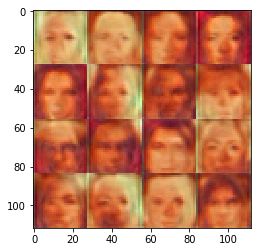

Epoch 1/1... Discriminator Loss: 0.0002... Generator Loss: 24.8056
Epoch 1/1... Discriminator Loss: 22.9445... Generator Loss: 12.9740
Epoch 1/1... Discriminator Loss: 4.5885... Generator Loss: 17.5012
Epoch 1/1... Discriminator Loss: 3.4544... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 5.1552... Generator Loss: 0.7601


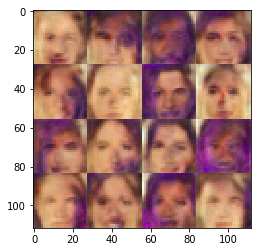

Epoch 1/1... Discriminator Loss: 0.0011... Generator Loss: 25.6293
Epoch 1/1... Discriminator Loss: 0.0314... Generator Loss: 26.2985
Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 26.9479
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 1.9571
Epoch 1/1... Discriminator Loss: 9.9718... Generator Loss: 0.0028


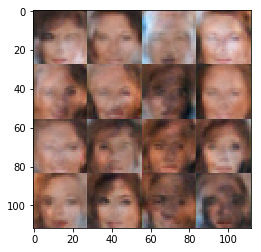

Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 16.3445
Epoch 1/1... Discriminator Loss: 0.1116... Generator Loss: 24.3086
Epoch 1/1... Discriminator Loss: 6.3172... Generator Loss: 19.3502
Epoch 1/1... Discriminator Loss: 0.0019... Generator Loss: 22.0818
Epoch 1/1... Discriminator Loss: 0.0689... Generator Loss: 6.9606


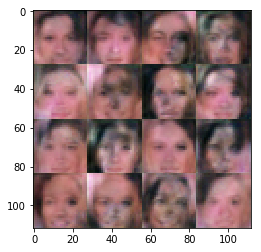

Epoch 1/1... Discriminator Loss: 2.6348... Generator Loss: 0.9369
Epoch 1/1... Discriminator Loss: 0.0349... Generator Loss: 8.2592
Epoch 1/1... Discriminator Loss: 13.1229... Generator Loss: 0.0087
Epoch 1/1... Discriminator Loss: 3.4858... Generator Loss: 13.6848
Epoch 1/1... Discriminator Loss: 12.7596... Generator Loss: 21.1300


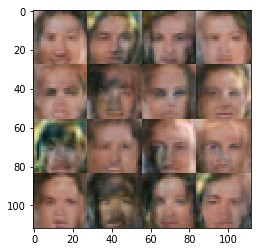

Epoch 1/1... Discriminator Loss: 0.0139... Generator Loss: 21.5055
Epoch 1/1... Discriminator Loss: 6.7334... Generator Loss: 9.3491
Epoch 1/1... Discriminator Loss: 0.2906... Generator Loss: 4.1236
Epoch 1/1... Discriminator Loss: 13.2982... Generator Loss: 0.0138
Epoch 1/1... Discriminator Loss: 0.2154... Generator Loss: 14.4546


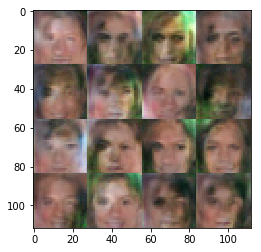

Epoch 1/1... Discriminator Loss: 8.2328... Generator Loss: 0.0459
Epoch 1/1... Discriminator Loss: 6.2781... Generator Loss: 0.0781
Epoch 1/1... Discriminator Loss: 6.4671... Generator Loss: 0.0508
Epoch 1/1... Discriminator Loss: 0.8453... Generator Loss: 8.1227
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 5.0686


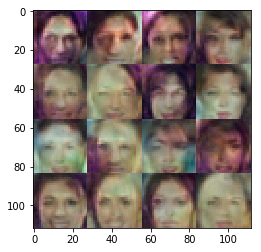

Epoch 1/1... Discriminator Loss: 0.2606... Generator Loss: 5.2149
Epoch 1/1... Discriminator Loss: 3.0692... Generator Loss: 0.4613
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 2.2597
Epoch 1/1... Discriminator Loss: 5.0069... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.6975... Generator Loss: 1.6438


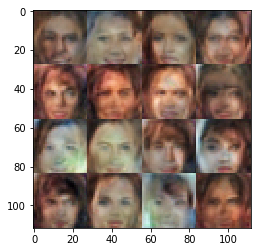

Epoch 1/1... Discriminator Loss: 0.1884... Generator Loss: 4.8414
Epoch 1/1... Discriminator Loss: 0.0617... Generator Loss: 9.6007
Epoch 1/1... Discriminator Loss: 0.3198... Generator Loss: 4.7724
Epoch 1/1... Discriminator Loss: 0.1316... Generator Loss: 6.0059
Epoch 1/1... Discriminator Loss: 2.2533... Generator Loss: 0.5630


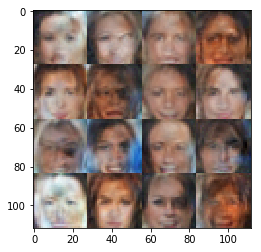

Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 8.6913
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 2.0915
Epoch 1/1... Discriminator Loss: 0.5347... Generator Loss: 5.2869
Epoch 1/1... Discriminator Loss: 2.2226... Generator Loss: 11.8310
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 1.2012


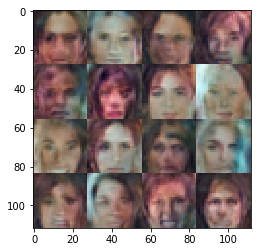

Epoch 1/1... Discriminator Loss: 2.5841... Generator Loss: 0.1840
Epoch 1/1... Discriminator Loss: 2.8418... Generator Loss: 0.1285
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 2.4145
Epoch 1/1... Discriminator Loss: 1.9469... Generator Loss: 1.3428
Epoch 1/1... Discriminator Loss: 3.4305... Generator Loss: 0.3696


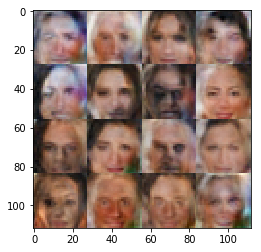

Epoch 1/1... Discriminator Loss: 1.8106... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 2.4154... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 1.5790
Epoch 1/1... Discriminator Loss: 0.7207... Generator Loss: 3.5245
Epoch 1/1... Discriminator Loss: 3.5386... Generator Loss: 0.1749


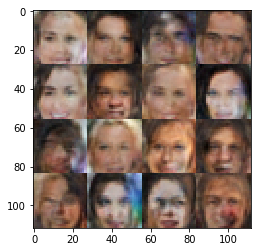

Epoch 1/1... Discriminator Loss: 1.7771... Generator Loss: 2.7488
Epoch 1/1... Discriminator Loss: 1.9710... Generator Loss: 0.5170
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.9845
Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 3.8044


In [100]:
batch_size = 256
z_dim = 128
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.